# Imports

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy.fft import fft, fftfreq
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
# from tensorflow.keras import Sequential
from tensorflow.keras import Input, Model
# from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, MultiHeadAttention
from tensorflow.keras.layers import Dense, Dropout, Flatten, MultiHeadAttention
from tensorflow.keras.utils import to_categorical
import zlib

# GPU

In [91]:
print('Tensorflow version: ', tf.__version__)
print("Nº GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version:  2.10.1
Nº GPUs Available:  1


In [92]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Arquivo
Exemplo: { TIPO_DE_SENSOR }-{ ESTADO }-{ CANAL-&-POSIÇÃO }-{ CANAL-&-POSIÇÃO }-{ DATA }.npy

In [93]:
# sensor_name = 'qing_cheng'
sensor_name = 'vallen'

model_index = 8

# --- Training settings ---

include_anomalia = True
include_spray = True

exclude_channel_1 = True

position_training = True

In [94]:
path_normalidade = f'./data/{sensor_name}/normalidade'
path_normalidade_anomalia = f'./data/{sensor_name}/normalidade_anomalia'
path_normalidade_spray = f'./data/{sensor_name}/normalidade_spray'

path_vazamento = f'./data/{sensor_name}/vazamento_5_bar'
path_vazamento_anomalia = f'./data/{sensor_name}/vazamento_5_bar_anomalia'
path_vazamento_spray = f'./data/{sensor_name}/vazamento_5_bar_spray'

In [95]:
model_name_df = pd.read_csv('./Model_Index.csv')
model_name_df.index = model_name_df.index + 1

In [96]:
model_name = model_name_df['nome_do_arquivo'].loc[model_index] if (model_index > 0)  else 'TEST'

print(f'Model file name: {model_name}')
print(f'Model index: {model_index}')

Model file name: position_canal_2_ruido
Model index: 8


# Obter dados

In [97]:
def load_npy_file(compressed_file_path: str, position_1, position_2, state):
    # Lê o arquivo comprimido
    with open(compressed_file_path, 'rb') as compressed_file:
        compressed_data = compressed_file.read()

    # Descomprime os dados
    decompressed_data = zlib.decompress(compressed_data)

    # Converte os dados descomprimidos em um array NumPy
    decompressed_array = np.frombuffer(decompressed_data, dtype=np.float64)

    # Supondo que os dados estão organizados em dois canais alternadamente
    channel_1 = decompressed_array[::2]  # Pega todos os elementos nos índices pares
    channel_2 = decompressed_array[1::2]  # Pega todos os elementos nos índices ímpares

    # DataFrame Pandas com os dados dos canais
    data = {
        'posicao_canal_1': position_1,
        'valor_canal_1': channel_1,
        'posicao_canal_2': position_2,
        'valor_canal_2': channel_2,
        'estado': state,
    }

    df = pd.DataFrame(data)

    return df

In [98]:
def get_file_paths(path: str):
    file_paths = []

    for dir_path, _, file_names in os.walk(path):
        for file_name in file_names:
            file_path = os.path.join(dir_path, file_name)
            file_paths.append(file_path)

    return file_paths

In [99]:
def mount_data_frames(paths: list[str]):
  data_frame_dict = {}

  for path in paths:
    file_name = path.split('/')[-1]
    data_info = file_name.split('-')[:4]
    # data_info[0] -> Tipo de sensor
    # data_info[1] -> Estado
    # data_info[2] e data_info[3] -> Canal & Posição

    state = data_info[1]
    channel_1 = data_info[2].split('_')[-1]
    channel_2 = data_info[3].split('_')[-1]

    # DF -> | POSICAO_CANAL_1 | POSICAO_VALOR_1 | POSICAO_CANAL_2 | POSICAO_VALOR_2 | ESTADO |
    df = load_npy_file(path, channel_1, channel_2, state)
    data_frame_dict[channel_2] = df

  return data_frame_dict

## Normalidade

In [100]:
paths_normalidade = get_file_paths(path_normalidade)

In [101]:
paths_normalidade

['./data/vallen/normalidade\\V-N-C1_1-C2_2-2024-03-12_16-17-07.npy',
 './data/vallen/normalidade\\V-N-C1_1-C2_3-2024-03-12_16-18-25.npy',
 './data/vallen/normalidade\\V-N-C1_1-C2_4-2024-03-12_16-19-48.npy']

In [102]:
df_normalidade = mount_data_frames(paths_normalidade)

In [103]:
df_normalidade

{'2':         posicao_canal_1  valor_canal_1 posicao_canal_2  valor_canal_2 estado
 0                     1      -1.014252               2       0.621490      N
 1                     1      -1.006918               2       0.610242      N
 2                     1      -0.995917               2       0.598993      N
 3                     1      -0.992249               2       0.587744      N
 4                     1      -0.973914               2       0.583994      N
 ...                 ...            ...             ...            ...    ...
 9999995               1       0.100544               2       0.032797      N
 9999996               1      -0.005802               2       0.021548      N
 9999997               1      -0.108481               2       0.010299      N
 9999998               1      -0.211159               2      -0.012199      N
 9999999               1      -0.310171               2      -0.019698      N
 
 [10000000 rows x 5 columns],
 '3':         posicao_canal

## Normalidade anomalia

In [104]:
paths_normalidade_anomalia = get_file_paths(path_normalidade_anomalia)

In [105]:
paths_normalidade_anomalia

['./data/vallen/normalidade_anomalia\\V-N_A-C1_1-C2_2-2024-03-12_16-28-14.npy',
 './data/vallen/normalidade_anomalia\\V-N_A-C1_1-C2_3-2024-03-12_16-26-13.npy',
 './data/vallen/normalidade_anomalia\\V-N_A-C1_1-C2_4-2024-03-12_16-23-47.npy']

In [106]:
df_normalidade_anomalia = mount_data_frames(paths_normalidade_anomalia)

In [107]:
df_normalidade_anomalia

{'2':         posicao_canal_1  valor_canal_1 posicao_canal_2  valor_canal_2 estado
 0                     1       1.926755               2       0.047795    N_A
 1                     1       1.930422               2       0.059044    N_A
 2                     1       1.937756               2       0.066544    N_A
 3                     1       1.941423               2       0.066544    N_A
 4                     1       1.945090               2       0.077793    N_A
 ...                 ...            ...             ...            ...    ...
 9999995               1       0.144549               2       0.182783    N_A
 9999996               1       0.144549               2       0.190282    N_A
 9999997               1       0.151883               2       0.190282    N_A
 9999998               1       0.148216               2       0.197781    N_A
 9999999               1       0.148216               2       0.201531    N_A
 
 [10000000 rows x 5 columns],
 '3':         posicao_canal

## Normalidade spray

In [108]:
paths_normalidade_spray = get_file_paths(path_normalidade_spray)

In [109]:
paths_normalidade_spray

['./data/vallen/normalidade_spray\\V-N_S-C1_1-C2_2-2024-03-13_08-44-34.npy',
 './data/vallen/normalidade_spray\\V-N_S-C1_1-C2_3-2024-03-13_08-45-56.npy',
 './data/vallen/normalidade_spray\\V-N_S-C1_1-C2_4-2024-03-13_08-47-34.npy']

In [110]:
df_normalidade_spray = mount_data_frames(paths_normalidade_spray)

In [111]:
df_normalidade_spray

{'2':         posicao_canal_1  valor_canal_1 posicao_canal_2  valor_canal_2 estado
 0                     1       0.617603               2      -0.064694    N_S
 1                     1       0.610269               2      -0.079692    N_S
 2                     1       0.602935               2      -0.090941    N_S
 3                     1       0.580932               2      -0.105940    N_S
 4                     1       0.555263               2      -0.117189    N_S
 ...                 ...            ...             ...            ...    ...
 9999995               1      -0.174488               2      -0.570895    N_S
 9999996               1      -0.130483               2      -0.548397    N_S
 9999997               1      -0.075477               2      -0.525900    N_S
 9999998               1      -0.020470               2      -0.503402    N_S
 9999999               1       0.034536               2      -0.484653    N_S
 
 [10000000 rows x 5 columns],
 '3':         posicao_canal

## Vazamento

In [112]:
paths_vazamento = get_file_paths(path_vazamento)

In [113]:
paths_vazamento

['./data/vallen/vazamento_5_bar\\V-V5b-C1_1-C2_2-2024-03-13_10-57-11.npy',
 './data/vallen/vazamento_5_bar\\V-V5b-C1_1-C2_3-2024-03-13_10-57-59.npy',
 './data/vallen/vazamento_5_bar\\V-V5b-C1_1-C2_4-2024-03-13_10-58-49.npy']

In [114]:
df_vazamento = mount_data_frames(paths_vazamento)

In [115]:
df_vazamento

{'2':         posicao_canal_1  valor_canal_1 posicao_canal_2  valor_canal_2 estado
 0                     1      -0.079144               2      -0.023448    V5b
 1                     1      -0.082811               2      -0.034697    V5b
 2                     1      -0.086478               2      -0.038446    V5b
 3                     1      -0.101146               2      -0.034697    V5b
 4                     1      -0.112148               2      -0.049695    V5b
 ...                 ...            ...             ...            ...    ...
 9999995               1       0.346239               2       0.047795    V5b
 9999996               1       0.313235               2       0.051545    V5b
 9999997               1       0.283898               2       0.055295    V5b
 9999998               1       0.247227               2       0.055295    V5b
 9999999               1       0.210556               2       0.047795    V5b
 
 [10000000 rows x 5 columns],
 '3':         posicao_canal

## Vazamento anomalia

In [116]:
paths_vazamento_anomalia = get_file_paths(path_vazamento_anomalia)

In [117]:
paths_vazamento_anomalia

['./data/vallen/vazamento_5_bar_anomalia\\V-V5b_A-C1_1-C2_3-2024-03-13_11-12-03.npy',
 './data/vallen/vazamento_5_bar_anomalia\\V-V5b_A-C1_1-C2_4-2024-03-13_11-09-10.npy']

In [118]:
df_vazamento_anomalia = mount_data_frames(paths_vazamento_anomalia)

In [119]:
df_vazamento_anomalia

{'3':         posicao_canal_1  valor_canal_1 posicao_canal_2  valor_canal_2 estado
 0                     1      -0.211159               3      -0.023448  V5b_A
 1                     1      -0.200158               3      -0.023448  V5b_A
 2                     1      -0.192824               3      -0.015948  V5b_A
 3                     1      -0.181822               3      -0.015948  V5b_A
 4                     1      -0.170821               3      -0.015948  V5b_A
 ...                 ...            ...             ...            ...    ...
 9999995               1       0.074874               3       0.036547  V5b_A
 9999996               1       0.096876               3       0.036547  V5b_A
 9999997               1       0.115212               3       0.032797  V5b_A
 9999998               1       0.144549               3       0.036547  V5b_A
 9999999               1       0.177552               3       0.036547  V5b_A
 
 [10000000 rows x 5 columns],
 '4':         posicao_canal

## Vazamento spray

In [120]:
paths_vazamento_spray = get_file_paths(path_vazamento_spray)

In [121]:
paths_vazamento_spray

['./data/vallen/vazamento_5_bar_spray\\V-V5b_S-C1_1-C2_2-2024-03-13_11-15-32.npy',
 './data/vallen/vazamento_5_bar_spray\\V-V5b_S-C1_1-C2_3-2024-03-13_11-12-53.npy',
 './data/vallen/vazamento_5_bar_spray\\V-V5b_S-C1_1-C2_4-2024-03-13_11-10-00.npy']

In [122]:
df_vazamento_spray = mount_data_frames(paths_vazamento_spray)

In [123]:
df_vazamento_spray

{'2':         posicao_canal_1  valor_canal_1 posicao_canal_2  valor_canal_2 estado
 0                     1       0.276564               2       0.051545  V5b_S
 1                     1       0.283898               2       0.044046  V5b_S
 2                     1       0.287565               2       0.047795  V5b_S
 3                     1       0.291232               2       0.040296  V5b_S
 4                     1       0.294899               2       0.040296  V5b_S
 ...                 ...            ...             ...            ...    ...
 9999995               1       0.529593               2      -0.053445  V5b_S
 9999996               1       0.522259               2      -0.064694  V5b_S
 9999997               1       0.492922               2      -0.075943  V5b_S
 9999998               1       0.470920               2      -0.075943  V5b_S
 9999999               1       0.448917               2      -0.079692  V5b_S
 
 [10000000 rows x 5 columns],
 '3':         posicao_canal

# Sliding Window

In [124]:
def sliding_window(data, size):
    windows = []
    for i in range(0, len(data), size):
        window = data.iloc[i:i+size]
        windows.append(window)
    return windows

In [125]:
# Tamanho da janela de slicing
window_size = 10000 # refere-se a 0.01s, considerando a coleta de 1MHz

In [126]:
# Aplicar a função de sliding window a cada dataframe em cada dicionário
normalidade_windows = {key: sliding_window(df, window_size) for key, df in df_normalidade.items()}
normalidade_anomalia_windows = {key: sliding_window(df, window_size) for key, df in df_normalidade_anomalia.items()}
normalidade_spray_windows = {key: sliding_window(df, window_size) for key, df in df_normalidade_spray.items()}

vazamento_windows = {key: sliding_window(df, window_size) for key, df in df_vazamento.items()}
vazamento_anomalia_windows = {key: sliding_window(df, window_size) for key, df in df_vazamento_anomalia.items()}
vazamento_spray_windows = {key: sliding_window(df, window_size) for key, df in df_normalidade_spray.items()}

In [127]:
print('---Normalidade---')
print(f'Rótulos: {normalidade_windows.keys()}')
print(f'Quantidade de janelas: {len(normalidade_windows["2"])}')
print(f'Tamanho das janela: {len(normalidade_windows["2"][0])}')
print('-----------------\n')

print('---Normalidade anomalia---')
print(f'Rótulos: {normalidade_anomalia_windows.keys()}')
print(f'Quantidade de janelas: {len(normalidade_anomalia_windows["2"])}')
print(f'Tamanho das janela: {len(normalidade_anomalia_windows["2"][0])}')
print('--------------------------\n')

print('---Normalidade spray---')
print(f'Rótulos: {normalidade_spray_windows.keys()}')
print(f'Quantidade de janelas: {len(normalidade_spray_windows["2"])}')
print(f'Tamanho das janela: {len(normalidade_spray_windows["2"][0])}')
print('-----------------------\n')

---Normalidade---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 10000
-----------------

---Normalidade anomalia---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 10000
--------------------------

---Normalidade spray---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 10000
-----------------------



In [128]:
print('---Vazamento---')
print(f'Rótulos: {vazamento_windows.keys()}')
print(f'Quantidade de janelas: {len(vazamento_windows["2"])}')
print(f'Tamanho das janela: {len(vazamento_windows["2"][0])}')
print('---------------\n')

print('---Vazamento anomalia---')
print(f'Rótulos: {vazamento_anomalia_windows.keys()}')
print(f'Quantidade de janelas: {len(vazamento_anomalia_windows["3"])}')
print(f'Tamanho das janela: {len(vazamento_anomalia_windows["3"][0])}')
print('------------------------\n')

print('---Vazamento spray---')
print(f'Rótulos: {vazamento_spray_windows.keys()}')
print(f'Quantidade de janelas: {len(vazamento_spray_windows["2"])}')
print(f'Tamanho das janela: {len(vazamento_spray_windows["2"][0])}')
print('---------------------\n')

---Vazamento---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 10000
---------------

---Vazamento anomalia---
Rótulos: dict_keys(['3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 10000
------------------------

---Vazamento spray---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 10000
---------------------



# Downsample

In [129]:
def downsample_dataframe(df, size):
    # Calcular o fator de downsample
    downsample_factor = len(df) // size
    
    # Selecionar cada enésimo elemento, onde n é o downsample_factor
    downsampled_df = df.iloc[::downsample_factor]
    
    return downsampled_df

In [130]:
def apply_downsample(df_dict: dict, size: int):
    df_dict_ds = {}
    
    # Loop sobre cada key:value em df_windows e downsample cada elemento
    for key, dfs in df_dict.items():
        df_dict_ds[key] = []
        
        for df in dfs:
            # Downsample do DataFrame
            df_dict_ds[key].append(downsample_dataframe(df, size).reset_index(drop=True))
            
    return df_dict_ds

In [131]:
# Valor de referência para o downsample
new_size = 2500

In [132]:
normalidade_windows_ds = apply_downsample(normalidade_windows, new_size)
normalidade_anomalia_windows_ds = apply_downsample(normalidade_anomalia_windows, new_size)
normalidade_spray_windows_ds = apply_downsample(normalidade_spray_windows, new_size)

vazamento_windows_ds = apply_downsample(vazamento_windows, new_size)
vazamento_anomalia_windows_ds = apply_downsample(vazamento_anomalia_windows, new_size)
vazamento_spray_windows_ds = apply_downsample(vazamento_spray_windows, new_size)

In [133]:
print('---Normalidade---')
print(f'Rótulos: {normalidade_windows_ds.keys()}')
print(f'Quantidade de janelas: {len(normalidade_windows_ds["2"])}')
print(f'Tamanho das janela: {len(normalidade_windows_ds["2"][0])}')
print('-----------------\n')

print('---Normalidade anomalia---')
print(f'Rótulos: {normalidade_anomalia_windows_ds.keys()}')
print(f'Quantidade de janelas: {len(normalidade_anomalia_windows_ds["2"])}')
print(f'Tamanho das janela: {len(normalidade_anomalia_windows_ds["2"][0])}')
print('--------------------------\n')

print('---Normalidade spray---')
print(f'Rótulos: {normalidade_spray_windows_ds.keys()}')
print(f'Quantidade de janelas: {len(normalidade_spray_windows_ds["2"])}')
print(f'Tamanho das janela: {len(normalidade_spray_windows_ds["2"][0])}')
print('-----------------------\n')

---Normalidade---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 2500
-----------------

---Normalidade anomalia---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 2500
--------------------------

---Normalidade spray---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 2500
-----------------------



In [134]:
print('---Vazamento---')
print(f'Rótulos: {vazamento_windows_ds.keys()}')
print(f'Quantidade de janelas: {len(vazamento_windows_ds["2"])}')
print(f'Tamanho das janela: {len(vazamento_windows_ds["2"][0])}')
print('---------------\n')

print('---Vazamento anomalia---')
print(f'Rótulos: {vazamento_anomalia_windows_ds.keys()}')
print(f'Quantidade de janelas: {len(vazamento_anomalia_windows_ds["3"])}')
print(f'Tamanho das janela: {len(vazamento_anomalia_windows_ds["3"][0])}')
print('------------------------\n')

print('---Vazamento spray---')
print(f'Rótulos: {vazamento_spray_windows_ds.keys()}')
print(f'Quantidade de janelas: {len(vazamento_spray_windows_ds["2"])}')
print(f'Tamanho das janela: {len(vazamento_spray_windows_ds["2"][0])}')
print('---------------------\n')

---Vazamento---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 2500
---------------

---Vazamento anomalia---
Rótulos: dict_keys(['3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 2500
------------------------

---Vazamento spray---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 2500
---------------------



### Optou-se por retirar dados de normalidade pela semelhança entre eles, com principal objetivo de reduzir custo computacional para treinar o modelo final

In [135]:
random.seed(42)

In [136]:
def normality_sampling(df_dict: dict, keep_percentage: float):
    df_dict_n = {}
    
    # Loop sobre cada key:value em df_windows
    for key, value in df_dict.items():
        # Número de elementos a serem mantidos
        num_to_keep = int(len(value) * keep_percentage)
        
        # Selecionar aleatoriamente os índices dos elementos a serem mantidos
        indices_to_keep = random.sample(range(len(value)), num_to_keep)
        
        # Filtrar a lista de dataframes mantendo apenas os elementos selecionados
        df_dict_n[key] = [value[i] for i in indices_to_keep]
        
    return df_dict_n
    
    # Agora df_windows contém apenas x% dos elementos originais para cada key:value

In [137]:
# Porcentagem de elementos a serem mantidos
keep_percentage_vazamento = 1 # tem que ser pelo menos 10%

keep_percentage_normalidade = keep_percentage_vazamento/9 # sempre 1/9 da quantidade de dados de cada classe para não gerar desbalanceamento

In [138]:
normalidade_windows_ds_n = normality_sampling(normalidade_windows_ds, keep_percentage_normalidade)
normalidade_anomalia_windows_ds_n = normality_sampling(normalidade_anomalia_windows_ds, keep_percentage_normalidade)
normalidade_spray_windows_ds_n = normality_sampling(normalidade_spray_windows_ds, keep_percentage_normalidade)

vazamento_windows_ds_n = normality_sampling(vazamento_windows_ds, keep_percentage_vazamento)
vazamento_anomalia_windows_ds_n = normality_sampling(vazamento_anomalia_windows_ds, keep_percentage_vazamento)
vazamento_spray_windows_ds_n = normality_sampling(vazamento_spray_windows_ds, keep_percentage_vazamento)

In [139]:
print('---Normalidade---')
print(f'Rótulos: {normalidade_windows_ds_n.keys()}')
print(f'Quantidade de janelas: {len(normalidade_windows_ds_n["2"])}')
print(f'Tamanho das janela: {len(normalidade_windows_ds_n["2"][0])}')
print('-----------------\n')

print('---Normalidade anomalia---')
print(f'Rótulos: {normalidade_anomalia_windows_ds_n.keys()}')
print(f'Quantidade de janelas: {len(normalidade_anomalia_windows_ds_n["2"])}')
print(f'Tamanho das janela: {len(normalidade_anomalia_windows_ds_n["2"][0])}')
print('--------------------------\n')

print('---Normalidade spray---')
print(f'Rótulos: {normalidade_spray_windows_ds_n.keys()}')
print(f'Quantidade de janelas: {len(normalidade_spray_windows_ds_n["2"])}')
print(f'Tamanho das janela: {len(normalidade_spray_windows_ds_n["2"][0])}')
print('-----------------------\n')

---Normalidade---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 111
Tamanho das janela: 2500
-----------------

---Normalidade anomalia---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 111
Tamanho das janela: 2500
--------------------------

---Normalidade spray---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 111
Tamanho das janela: 2500
-----------------------



In [140]:
print('---Vazamento---')
print(f'Rótulos: {vazamento_windows_ds_n.keys()}')
print(f'Quantidade de janelas: {len(vazamento_windows_ds_n["2"])}')
print(f'Tamanho das janela: {len(vazamento_windows_ds_n["2"][0])}')
print('---------------\n')

print('---Vazamento anomalia---')
print(f'Rótulos: {vazamento_anomalia_windows_ds_n.keys()}')
print(f'Quantidade de janelas: {len(vazamento_anomalia_windows_ds_n["3"])}')
print(f'Tamanho das janela: {len(vazamento_anomalia_windows_ds_n["3"][0])}')
print('------------------------\n')

print('---Vazamento spray---')
print(f'Rótulos: {vazamento_spray_windows_ds_n.keys()}')
print(f'Quantidade de janelas: {len(vazamento_spray_windows_ds_n["2"])}')
print(f'Tamanho das janela: {len(vazamento_spray_windows_ds_n["2"][0])}')
print('---------------------\n')

---Vazamento---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 2500
---------------

---Vazamento anomalia---
Rótulos: dict_keys(['3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 2500
------------------------

---Vazamento spray---
Rótulos: dict_keys(['2', '3', '4'])
Quantidade de janelas: 1000
Tamanho das janela: 2500
---------------------



# FFT

In [141]:
def fft_transform(df, canal, fs, n):
    t = 1/fs
    # x = np.linspace(0.0, N*T, N, endpoint=False)
    y_values = df[canal].values

    # valor imaginario
    yf = fft(y_values)
    xf = fftfreq(n, t)[:n//2]

    yf = 2.0/n * np.abs(yf[:n//2])

    return xf, yf

In [142]:
def mount_fft_data_frames(df_windows, element_size, fs, n):
    windows_fft = {}
    xf1, xf2 = None, None
    
    # Inicializando cada valor do dicionário como uma lista de dataframes vazios
    for sensor_position in df_windows:
        windows_fft[sensor_position] = [pd.DataFrame(columns=['canal_1', 'canal_2']) for _ in range(element_size)]
    
    # tira a fft e filtra para todas as janelas de tempo em df_windows e salva em df_windows_fft
    for sensor_position in df_windows:
        for index, _ in enumerate(df_windows[sensor_position]):
            xf1, windows_fft[sensor_position][index]['canal_1'] = fft_transform(df_windows[sensor_position][index], 'valor_canal_1', fs, n)
            xf2, windows_fft[sensor_position][index]['canal_2'] = fft_transform(df_windows[sensor_position][index], 'valor_canal_2', fs, n)
            windows_fft[sensor_position][index].reset_index(drop=True, inplace=True)
            
    return windows_fft, xf1, xf2

In [143]:
fft_fs = 1000000.0/(window_size/new_size)
fft_N = new_size

## Normalidade

In [144]:
normalidade_dfs_fft_size = len(normalidade_windows_ds_n['2'])
normalidade_windows_fft, normalidade_xf1, normalidade_xf2 = mount_fft_data_frames(normalidade_windows_ds_n, normalidade_dfs_fft_size, fft_fs, fft_N)

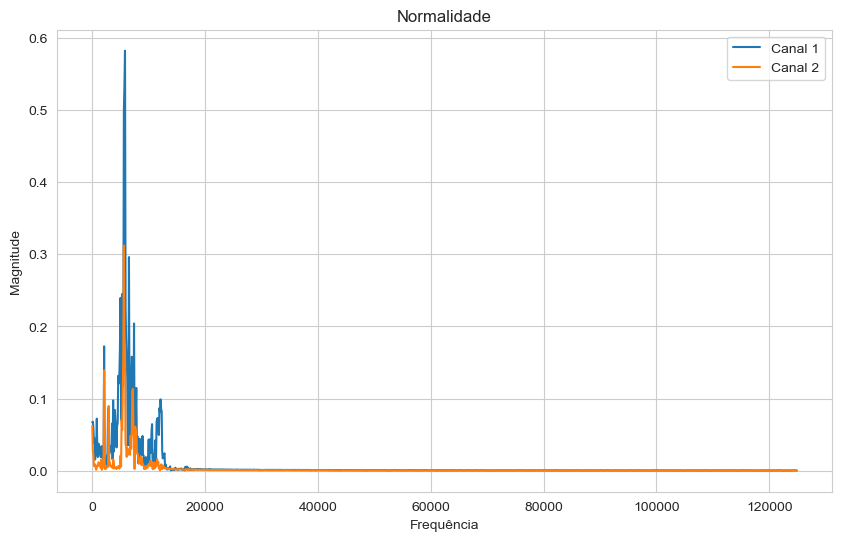

In [145]:
plt.figure(figsize=(10, 6))
plt.plot(normalidade_xf1, normalidade_windows_fft['2'][12]['canal_1'], label='Canal 1')
plt.plot(normalidade_xf1, normalidade_windows_fft['2'][12]['canal_2'], label='Canal 2')
plt.xlabel('Frequência')
plt.ylabel('Magnitude')
plt.title('Normalidade')
plt.legend()
plt.show()

In [146]:
print(normalidade_xf1[150])
print(normalidade_xf1[700])

15000.0
70000.0


## Normalidade anomalia

In [147]:
normalidade_anomalia_dfs_fft_size = len(normalidade_anomalia_windows_ds_n['2'])
normalidade_anomalia_windows_fft, normalidade_anomalia_xf1, normalidade_anomalia_xf2 = mount_fft_data_frames(normalidade_anomalia_windows_ds_n, normalidade_anomalia_dfs_fft_size, fft_fs, fft_N)

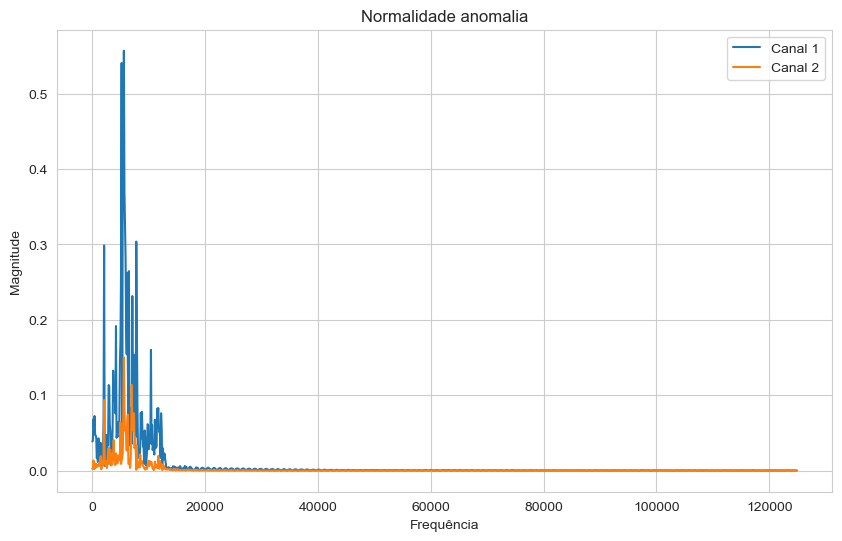

In [148]:
plt.figure(figsize=(10, 6))
plt.plot(normalidade_anomalia_xf1, normalidade_anomalia_windows_fft['2'][12]['canal_1'], label='Canal 1')
plt.plot(normalidade_anomalia_xf1, normalidade_anomalia_windows_fft['2'][12]['canal_2'], label='Canal 2')
plt.xlabel('Frequência')
plt.ylabel('Magnitude')
plt.title('Normalidade anomalia')
plt.legend()
plt.show()

In [149]:
print(normalidade_anomalia_xf1[150])
print(normalidade_anomalia_xf1[700])

15000.0
70000.0


## Normalidade spray

In [150]:
normalidade_spray_dfs_fft_size = len(normalidade_spray_windows_ds_n['2'])
normalidade_spray_windows_fft, normalidade_spray_xf1, normalidade_spray_xf2 = mount_fft_data_frames(normalidade_spray_windows_ds_n, normalidade_spray_dfs_fft_size, fft_fs, fft_N)

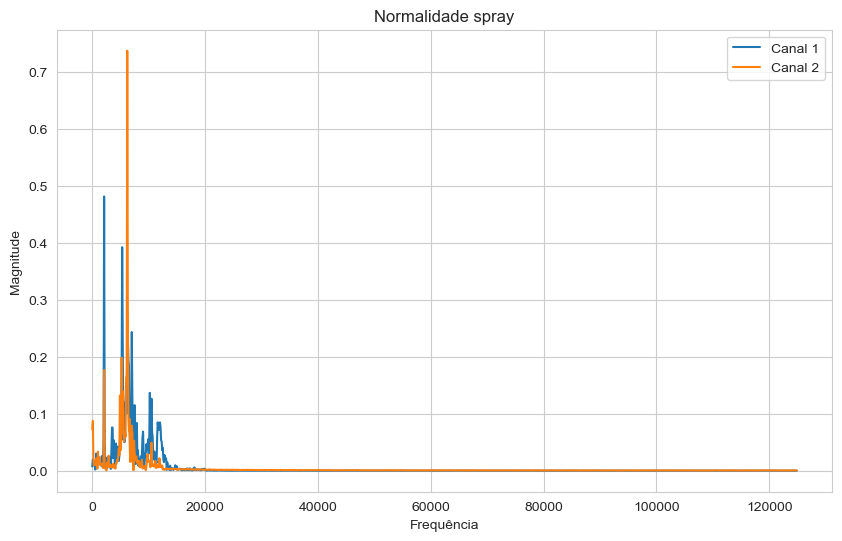

In [151]:
plt.figure(figsize=(10, 6))
plt.plot(normalidade_spray_xf1, normalidade_spray_windows_fft['2'][12]['canal_1'], label='Canal 1')
plt.plot(normalidade_spray_xf1, normalidade_spray_windows_fft['2'][12]['canal_2'], label='Canal 2')
plt.xlabel('Frequência')
plt.ylabel('Magnitude')
plt.title('Normalidade spray')
plt.legend()
plt.show()

In [152]:
print(normalidade_spray_xf1[150])
print(normalidade_spray_xf1[700])

15000.0
70000.0


## Vazamento

In [153]:
vazamento_dfs_fft_size = len(vazamento_windows_ds_n['2'])
vazamento_windows_fft, vazamento_xf1, vazamento_xf2 = mount_fft_data_frames(vazamento_windows_ds_n, vazamento_dfs_fft_size, fft_fs, fft_N)

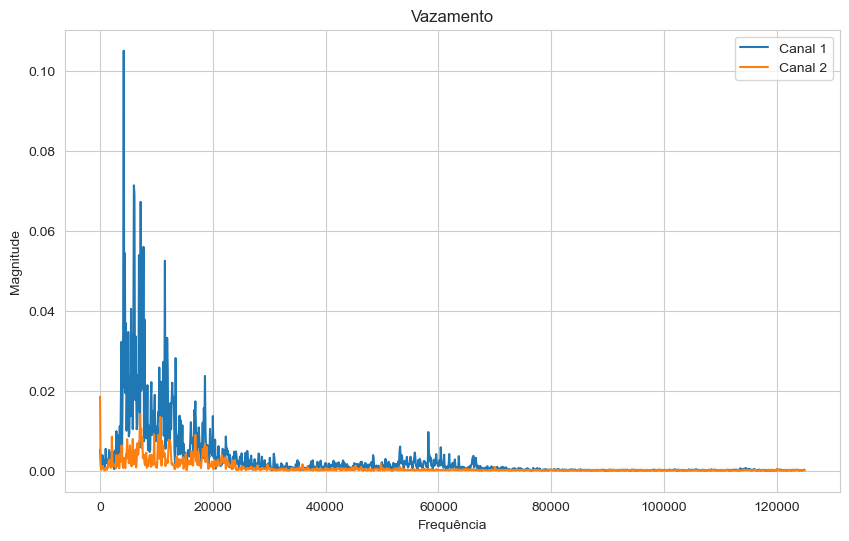

In [154]:
plt.figure(figsize=(10, 6))
plt.plot(vazamento_xf1, vazamento_windows_fft['2'][12]['canal_1'], label='Canal 1')
plt.plot(vazamento_xf1, vazamento_windows_fft['2'][12]['canal_2'], label='Canal 2')
plt.xlabel('Frequência')
plt.ylabel('Magnitude')
plt.title('Vazamento')
plt.legend()
plt.show()

In [155]:
print(vazamento_xf1[150])
print(vazamento_xf1[700])

15000.0
70000.0


## Vazamento anomalia

In [156]:
vazamento_anomalia_dfs_fft_size = len(vazamento_anomalia_windows_ds_n['3'])
vazamento_anomalia_windows_fft, vazamento_anomalia_xf1, vazamento_anomalia_xf2 = mount_fft_data_frames(vazamento_anomalia_windows_ds_n, vazamento_anomalia_dfs_fft_size, fft_fs, fft_N)

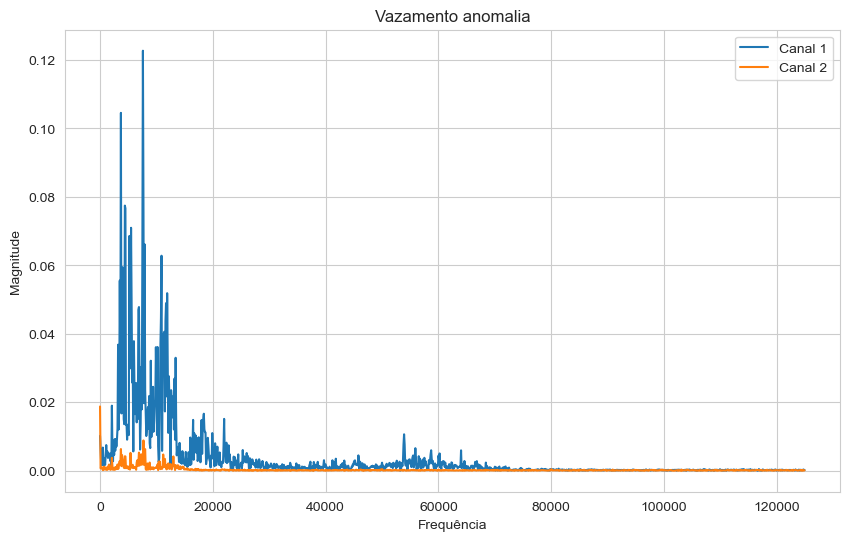

In [157]:
plt.figure(figsize=(10, 6))
plt.plot(vazamento_anomalia_xf1, vazamento_anomalia_windows_fft['3'][12]['canal_1'], label='Canal 1')
plt.plot(vazamento_anomalia_xf1, vazamento_anomalia_windows_fft['3'][12]['canal_2'], label='Canal 2')
plt.xlabel('Frequência')
plt.ylabel('Magnitude')
plt.title('Vazamento anomalia')
plt.legend()
plt.show()

In [158]:
print(vazamento_anomalia_xf1[150])
print(vazamento_anomalia_xf1[700])

15000.0
70000.0


## Vazamento spray

In [159]:
vazamento_spray_dfs_fft_size = len(vazamento_spray_windows_ds_n['2'])
vazamento_spray_windows_fft, vazamento_spray_xf1, vazamento_spray_xf2 = mount_fft_data_frames(vazamento_spray_windows_ds_n, vazamento_spray_dfs_fft_size, fft_fs, fft_N)

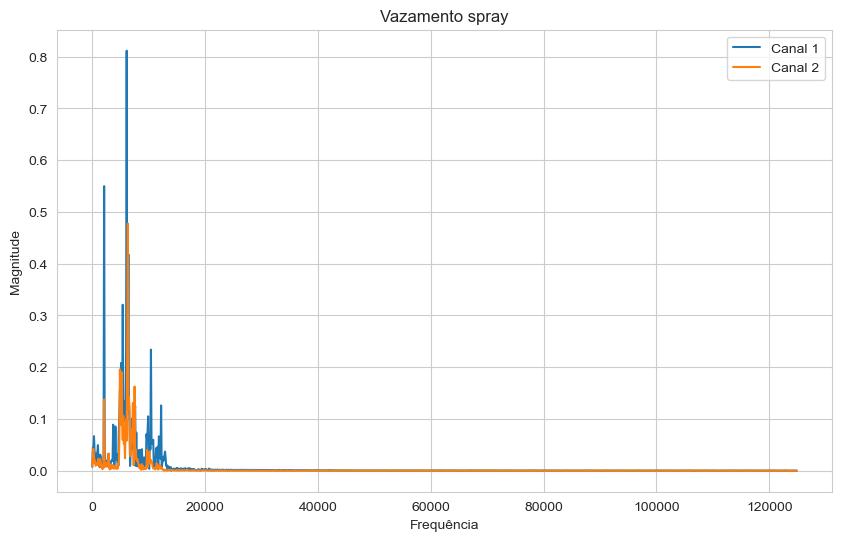

In [160]:
plt.figure(figsize=(10, 6))
plt.plot(vazamento_spray_xf1, vazamento_spray_windows_fft['2'][12]['canal_1'], label='Canal 1')
plt.plot(vazamento_spray_xf1, vazamento_spray_windows_fft['2'][12]['canal_2'], label='Canal 2')
plt.xlabel('Frequência')
plt.ylabel('Magnitude')
plt.title('Vazamento spray')
plt.legend()
plt.show()

In [161]:
print(vazamento_spray_xf1[150])
print(vazamento_spray_xf1[700])

15000.0
70000.0


## Sampling

In [162]:
def fft_sampling(df_windows_fft: dict):
    df_windows_fft_sampled = {}
    
    for sensor_position in df_windows_fft:
        df_windows_fft_sampled[sensor_position] = []
        
        for index, sample in enumerate(df_windows_fft[sensor_position]):
            df_windows_fft_sampled[sensor_position].append(sample[0:700].reset_index(drop=True))
            
    return df_windows_fft_sampled

In [163]:
normalidade_windows_fft_s = fft_sampling(normalidade_windows_fft)
normalidade_anomalia_windows_fft_s = fft_sampling(normalidade_anomalia_windows_fft)
normalidade_spray_windows_fft_s = fft_sampling(normalidade_spray_windows_fft)

vazamento_windows_fft_s = fft_sampling(vazamento_windows_fft)
vazamento_anomalia_windows_fft_s = fft_sampling(vazamento_anomalia_windows_fft)
vazamento_spray_windows_fft_s = fft_sampling(vazamento_spray_windows_fft)

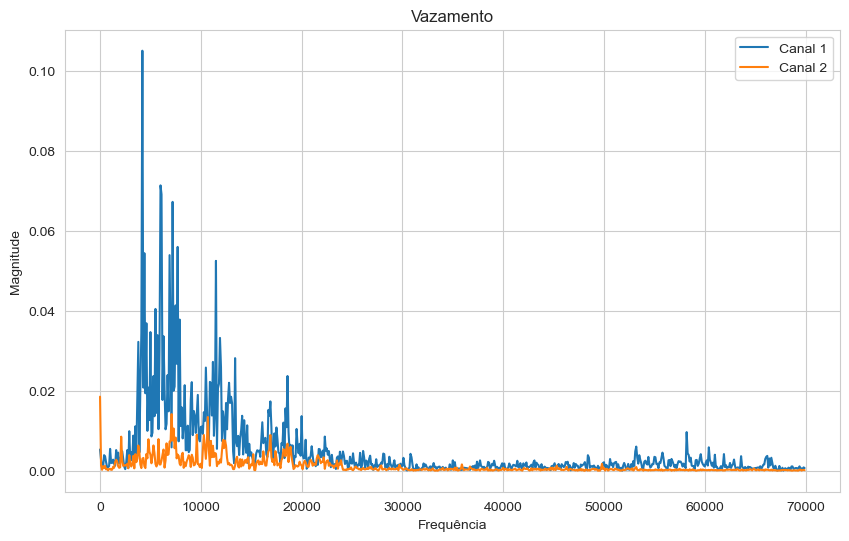

In [164]:
plt.figure(figsize=(10, 6))
# plt.plot(vazamento_xf1[150:700], vazamento_windows_fft_s['2'][12]['canal_1'], label='Canal 1')
# plt.plot(vazamento_xf1[150:700], vazamento_windows_fft_s['2'][12]['canal_2'], label='Canal 2')
plt.plot(vazamento_xf1[0:700], vazamento_windows_fft_s['2'][12]['canal_1'], label='Canal 1')
plt.plot(vazamento_xf1[0:700], vazamento_windows_fft_s['2'][12]['canal_2'], label='Canal 2')
plt.xlabel('Frequência')
plt.ylabel('Magnitude')
plt.title('Vazamento')
plt.legend()
plt.show()

# Standard-Scaler

In [165]:
def apply_scaler(df_windows_fft: dict):
    df_windows_fft_scaled = {}
    
    for key, value_list in df_windows_fft.items():
        df_windows_fft_scaled[key] = []
        
        for df in value_list:
            df_scaled = pd.DataFrame()
            
            # Inicialize o StandardScaler
            scaler = StandardScaler()
            
            # Ajuste o scaler aos dados e transforme os valores
            scaled_values_1 = scaler.fit_transform(df[['canal_1']])
            scaled_values_2 = scaler.fit_transform(df[['canal_2']])
            
            # Substitua os valores na coluna 'valor_sensor' pelos valores normalizados
            df_scaled['canal_1'] = scaled_values_1.flatten()
            df_scaled['canal_2'] = scaled_values_2.flatten()
            
            df_windows_fft_scaled[key].append(df_scaled)
            
    return df_windows_fft_scaled

In [166]:
normalidade_windows_fft_scaled = apply_scaler(normalidade_windows_fft_s)
normalidade_anomalia_windows_fft_scaled = apply_scaler(normalidade_anomalia_windows_fft_s)
normalidade_spray_windows_fft_scaled = apply_scaler(normalidade_windows_fft_s)

vazamento_windows_fft_scaled = apply_scaler(vazamento_windows_fft_s)
vazamento_anomalia_windows_fft_scaled = apply_scaler(vazamento_anomalia_windows_fft_s)
vazamento_spray_windows_fft_scaled = apply_scaler(vazamento_spray_windows_fft_s)

# Prepare Labels

In [167]:
all_windows = []
labels = []

In [168]:
def prepare_info(df_windows_fft: dict, label):    
    for key, value in df_windows_fft.items():
        data = []
        
        if exclude_channel_1:
            for df in value:
                data.append(df.drop('canal_1', axis=1))
                
        else:
            data = value
        
        if position_training and (label != 0):
            labels.extend([int(key) - 1] * len(value))
            
        else:
            labels.extend([label] * len(value))
        
        all_windows.extend(data)

In [169]:
prepare_info(normalidade_windows_fft_scaled, 0)
prepare_info(vazamento_windows_fft_scaled, 1)

if include_anomalia:
    prepare_info(normalidade_anomalia_windows_fft_scaled, 0)
    prepare_info(vazamento_anomalia_windows_fft_scaled, 1)

if include_spray:
    prepare_info(normalidade_spray_windows_fft_scaled, 0)
    prepare_info(vazamento_spray_windows_fft_scaled, 1)

In [170]:
# Convertendo as listas de dataframes em uma única lista de numpy arrays
X = np.array(all_windows)
y = np.array(labels)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training

In [172]:
input_length = 1 if exclude_channel_1 else 2
print(f"Input length: {input_length}")

Input length: 1


In [173]:
output_length = len(np.unique(labels))
print(f"Output length: {output_length}")

Output length: 4


In [174]:
def baseline_model(num_units, dense_activation, drop, optimizer):
    input_layer = Input(shape=(len(X[0]), input_length))

    layer_1 = MultiHeadAttention(num_heads=2, key_dim=2)(input_layer, input_layer)
    layer_1 = Flatten()(layer_1)

    # layer_1 = LSTM(num_units//4)(input_layer)

    layer_1 = Dropout(drop)(layer_1)

    layer_2 = Dense(num_units, activation=dense_activation)(layer_1)
    layer_2 = Dropout(drop)(layer_2)

    layer_3 = Dense(num_units//2, activation=dense_activation)(layer_2)
    layer_3 = Dropout(drop)(layer_3)

    output_layer = Dense(output_length, activation='softmax')(layer_3)
    base_model = Model(inputs = input_layer, outputs = output_layer)

    base_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return base_model

In [175]:
# num_units_list = [32]
# drop_list = [0.2] 
# batch_sizes = [8]
# epochs_list = [10]
# optimizer_list = ['Adam']
# dense_activations = ["relu"]

# num_units_list = [32, 64, 128, 256, 512, 1024]
# drop_list = [0.2, 0.5] 
# batch_sizes = [32]
# epochs_list = [10, 100] 
# optimizer_list = ['Adam']
# dense_activations = ["relu"]

# num_units_list = [1024]
# drop_list = [0.2] 
# batch_sizes = [8]
# epochs_list = [50]
# optimizer_list = ['Adam']
# dense_activations = ["relu"]

# num_units_list = [32]
# drop_list = [0.3]
# batch_sizes = [16]
# epochs_list = [130]
# optimizer_list = ['Adam']
# dense_activations = ["relu"]

# num_units_list = [512]
# drop_list = [0.2]
# batch_sizes = [8]
# epochs_list = [60]
# optimizer_list = ['Adam']
# dense_activations = ["relu"]

# num_units_list = [32, 64, 128]
# drop_list = [0.3, 0.5]
# batch_sizes = [32, 64]
# epochs_list = [75, 100]
# optimizer_list = ['Adam']
# dense_activations = ["relu"]

# batch_sizes < drop_list < epochs_list < num_units_list

In [176]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
best_model = None
best_accuracy = 0

In [177]:
# Loop over the different types of layers and hyperparameters
for num_units in num_units_list:
    for batch_size in batch_sizes:
        for epochs in epochs_list:
            for dense_activation in dense_activations:
                for drop in drop_list:
                    for optimizer in optimizer_list:
                        print(f"Training model with {num_units} units, batch size {batch_size}, epochs {epochs}, dense_activation {dense_activation}, dropout {drop}, optimizer {optimizer}...")
                        fold_results = []
                        fold_number = 0
                        accuracy = 0
                        precision = 0
                        recall = 0
                        f1 = 0
                        for train_index, test_index in kf.split(X, y):
                            X_train, X_test = X[train_index], X[test_index]
                            y_train, y_test = y[train_index], y[test_index]
                            y_train_encoded = to_categorical(y_train)
                            y_test_encoded = to_categorical(y_test)

                            # Creating and training the model
                            model = baseline_model(num_units, dense_activation, drop, optimizer)
                            history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_encoded), verbose=1)

                            # Evaluating the model
                            y_pred = np.argmax(model.predict(X_test), axis=-1)

                            new_acc = accuracy_score(np.argmax(y_test_encoded, axis=1), y_pred)
                            accuracy += new_acc

                            new_precision = precision_score(np.argmax(y_test_encoded, axis=1), y_pred, average='weighted')
                            precision += new_precision

                            new_recall = recall_score(np.argmax(y_test_encoded, axis=1), y_pred, average='weighted')
                            recall += new_recall

                            new_f1 = f1_score(np.argmax(y_test_encoded, axis=1), y_pred, average='weighted')
                            f1 += new_f1

                            fold_results.append((new_acc, new_precision, new_recall, new_f1))

                            fold_number += 1

                        # Update best model
                        if (accuracy/fold_number) > best_accuracy:
                            best_accuracy = accuracy/fold_number
                            best_model = model
                            best_dense_activation = dense_activation
                            best_num_units = num_units
                            best_batch_size = batch_size
                            best_epochs = epochs
                            best_dropout = drop
                            best_optimizer = optimizer

                        # Saving the results for later analysis
                        results.append((num_units, batch_size, epochs, dense_activation, drop, optimizer, fold_results))

# Convert the best result into a DataFrame
best_results = []
best_results.append((best_accuracy, best_dense_activation, best_num_units, best_batch_size, best_epochs, best_dropout, best_optimizer))
best_results_df = pd.DataFrame(best_results, columns=['best_accuracy', 'best_dense_activation', 'best_num_units', 'best_batch_size', 'best_epochs', 'best_dropout', 'best_optimizer'])
best_results_df.to_csv(f'./model/{sensor_name}/{model_index}/{model_name}-best_results.csv', index=False)

# Convert the results into a DataFrame
results_df = pd.DataFrame(results, columns=['Num Units', 'Batch Size', 'Epochs', 'Dense Activation', 'drop', 'optimizer', 'Fold Results (accuracy, precision, recall, f1)'])
results_df.to_csv(f'./model/{sensor_name}/{model_index}/{model_name}-all_results.csv', index=False)

# Save the best model to .h5 file
best_model.save(f'./model/{sensor_name}/{model_index}/{model_name}-best_model.h5')

Training model with 512 units, batch size 8, epochs 60, dense_activation relu, dropout 0.2, optimizer Adam...
Epoch 1/60
900/900 [==============================] - 10s 10ms/step - loss: 0.5736 - accuracy: 0.7843 - val_loss: 0.1586 - val_accuracy: 0.9539
Epoch 2/60
900/900 [==============================] - 8s 9ms/step - loss: 0.1803 - accuracy: 0.9458 - val_loss: 0.1203 - val_accuracy: 0.9506
Epoch 3/60
900/900 [==============================] - 7s 8ms/step - loss: 0.1290 - accuracy: 0.9612 - val_loss: 0.0879 - val_accuracy: 0.9744
Epoch 4/60
900/900 [==============================] - 7s 8ms/step - loss: 0.1142 - accuracy: 0.9626 - val_loss: 0.0656 - val_accuracy: 0.9789
Epoch 5/60
900/900 [==============================] - 7s 8ms/step - loss: 0.0802 - accuracy: 0.9729 - val_loss: 0.0960 - val_accuracy: 0.9656
Epoch 6/60
900/900 [==============================] - 7s 8ms/step - loss: 0.0878 - accuracy: 0.9753 - val_loss: 0.0709 - val_accuracy: 0.9761
Epoch 7/60
900/900 [================

In [178]:
# Save X and y to npy file
np.save(f'./model/{sensor_name}/{model_index}/{model_name}-x.npy', X)
np.save(f'./model/{sensor_name}/{model_index}/{model_name}-y.npy', y)